In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import random # we don't fix seed here so can use to re sample test patients

Global seed set to 0


In [21]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


# Read data

In [2]:
# adt.h5ad is full dataset, change to adt_test.h5ad for a smaller subset
adt = sc.read('/home/icb/anastasia.litinetskaya/data/haniffa-2021/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 624325 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [3]:
# rna.h5ad is full dataset, change to rna_test.h5ad for a smaller subset
rna = sc.read('/home/icb/anastasia.litinetskaya/data/haniffa-2021/rna.h5ad')
rna

AnnData object with n_obs × n_vars = 624325 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [4]:
idx = adt.obs['patient_id'].sort_values().index # need to sort by patient for the data loader

In [5]:
adt = adt[idx].copy()
rna = rna[idx].copy()

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# MIL

In [6]:
# arange modality adatas into one adata
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],
    groups = [[0], [0]],
    layers = [['count'], [None]],
)
adata

AnnData object with n_obs × n_vars = 624325 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [7]:
# if want to leave out patients as test uncomment the next two cells
number_of_test_patients = 13
patients = list(adata.obs['patient_id'].cat.categories)
test_patient_ids = random.sample(patients, number_of_test_patients)
adata[adata.obs.patient_id.isin(test_patient_ids)].obs[['Status_on_day_collection_summary', 'patient_id']].drop_duplicates().groupby('Status_on_day_collection_summary').count() # check class distribution for test set

,patient_id
Status_on_day_collection_summary,
Asymptomatic,1
Critical,2
Healthy,6
Mild,2
Moderate,1
Severe,1


In [8]:
# subset
adata_test = adata[adata.obs.patient_id.isin(test_patient_ids)].copy()
adata = adata[~adata.obs.patient_id.isin(test_patient_ids)].copy()

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
mtg.model.MultiVAE_MIL.setup_anndata(
            adata, 
            class_label="Status_on_day_collection_summary",
            rna_indices_end=4000,
            categorical_covariate_keys=['Sex', 'Age_interval', 'patient_id'],
            continuous_covariate_keys=None,
        )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 559534 cells, 4192 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 4 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [10]:
mil = mtg.model.MultiVAE_MIL(
            adata, 
            modality_lengths=[4000, 192],
            losses=['nb', 'mse'],
            loss_coefs={'kl': 1e-5, 'integ': 0},
            class_label='Status_on_day_collection_summary',
            patient_label='patient_id',
            scoring='gated_attn', # or 'attn'
            add_patient_to_classifier=False, # whether to use patient embeddings for classification
            hierarchical_attn=True, # whether to have hierarchical attention or just cell attention   
        )

In [11]:
mil.train(
    max_epochs=5, 
    batch_size=256,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Epoch 1/5:  20%|██        | 1/5 [00:32<02:10, 32.51s/it, loss=730, v_num=1]

Metric elbo_validation improved. New best score: 723.420


Epoch 2/5:  40%|████      | 2/5 [01:08<01:43, 34.54s/it, loss=596, v_num=1]

Metric elbo_validation improved by 126.896 >= min_delta = 0.0. New best score: 596.524


Epoch 3/5:  60%|██████    | 3/5 [01:47<01:13, 36.52s/it, loss=568, v_num=1]

Metric elbo_validation improved by 31.222 >= min_delta = 0.0. New best score: 565.303


Epoch 4/5:  80%|████████  | 4/5 [02:27<00:37, 37.58s/it, loss=572, v_num=1]

Metric elbo_validation improved by 22.479 >= min_delta = 0.0. New best score: 542.823


Epoch 5/5: 100%|██████████| 5/5 [03:07<00:00, 38.58s/it, loss=517, v_num=1]

Metric elbo_validation improved by 17.031 >= min_delta = 0.0. New best score: 525.792


Epoch 5/5: 100%|██████████| 5/5 [03:09<00:00, 37.91s/it, loss=517, v_num=1]


In [12]:
mil_out = mil.get_latent_representation(batch_size=256)
latent, cell_attn, cov_attn, _ = mil_out

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
adata.obsm['latent'] = latent
adata.obs['cell_attn'] = cell_attn

In [16]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

... storing 'feature_types' as categorical
... storing 'highly_variable' as categorical


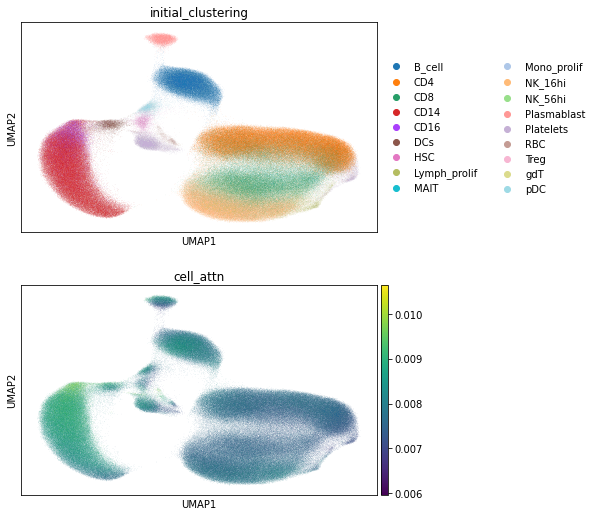

In [17]:
sc.pl.umap(adata, color=['initial_clustering', 'cell_attn'], ncols=1)

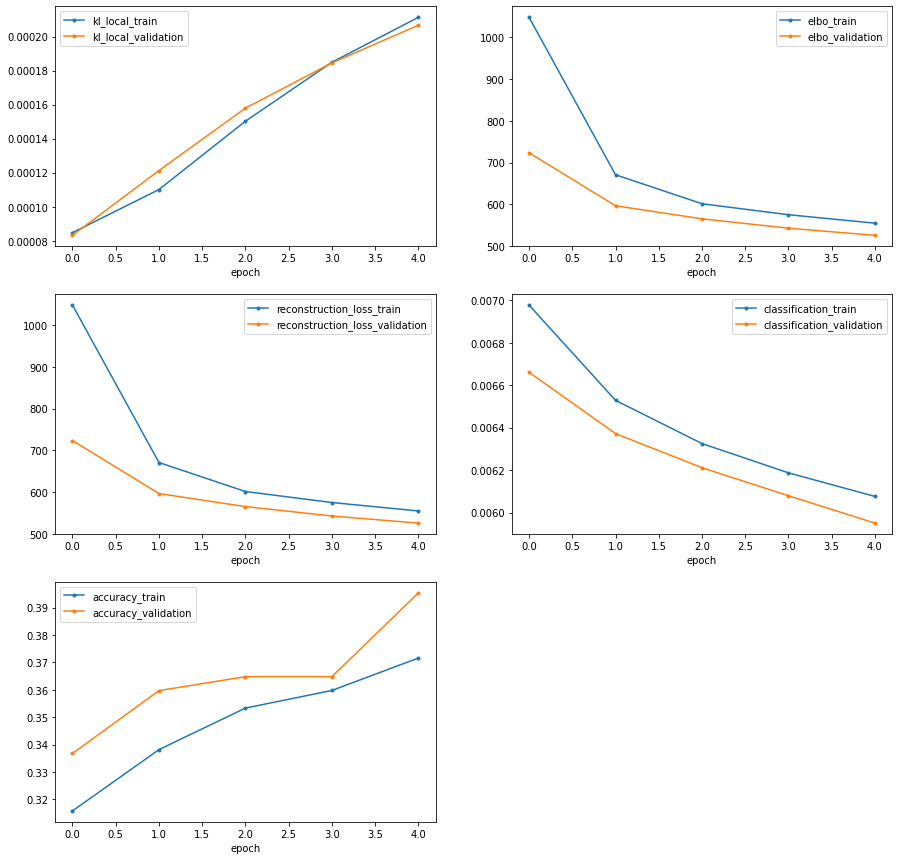

In [18]:
df = pd.DataFrame(mil.history['train_loss_step'])
for key in mil.history.keys():
    if key != 'train_loss_step':
        df = df.join(mil.history[key])

df['epoch'] = df.index

plt.figure(figsize=(15, 15))
loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'classification', 'accuracy']
nrows = 3

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+1)
    plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
    plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')
    plt.xlabel('epoch')
    plt.legend()

In [19]:
# first is always molecular information, 
# then categorical covariate as they were specified with setup_anndata, 
# then continuous
cov_attn.shape

(559534, 3)

In [20]:
# i.e. in this case
adata.obs['molecular_attn'] = cov_attn[:, 0]
adata.obs['sex_attn'] = cov_attn[:, 1]
adata.obs['age_attn'] = cov_attn[:, 2]